# Deep Image Priors with ViT

## ViT Implementation

In [1]:
import torch
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm import trange

from vit.models import HourglassViT
from vit.datasets import SingleImageDataset

## Set up Dataset

In [3]:
ds = SingleImageDataset(transform=transforms.ToTensor(), target_transform=transforms.ToTensor())
dl = DataLoader(ds, batch_size=4, num_workers=2)

## Load Model

In [4]:
patch_size = (16, 16)

device = torch.device('cuda')

model = HourglassViT(
        image_size=ds.image_size,
        patch_size=patch_size,
        num_classes=10,
        dim=1024,
        depth=6,
        heads=16,
        mlp_dim=2048,
        dropout=0.1,
        emb_dropout=0.1).float().to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [5]:
model.train()

train_loss = []

epoch_progress = trange(100)
for epoch in epoch_progress:
    epoch_progress.set_description(f'Epoch {epoch}')
    running_loss = 0.
    running_count = 0

    for inputs, outputs in dl:
        optimizer.zero_grad()

        pred_outputs = model(inputs.to(device))
        loss = criterion(outputs.to(device), pred_outputs)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_count += inputs.size(0)

        epoch_progress.set_postfix({
            'train loss': f'{running_loss / running_count:.3f}'
        })

    train_loss.append(running_loss / running_count)
    torch.save(model.state_dict(), f'checkpoints/model_checkpoint-{epoch}.pt')

Epoch 99: 100%|██████████| 100/100 [14:03<00:00,  8.44s/it, train loss=366.830]


In [14]:
model.load_state_dict(torch.load('checkpoints/model_checkpoint-50.pt'))

<All keys matched successfully>

## Test Output

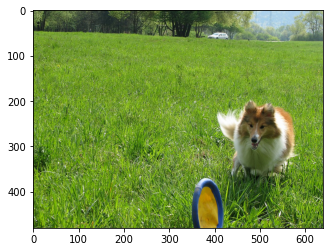

In [12]:
plt.imshow(ds.image / 255)
plt.show()

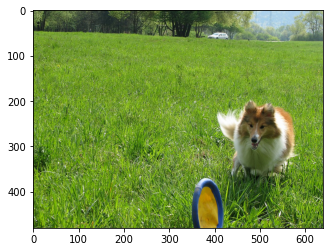

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


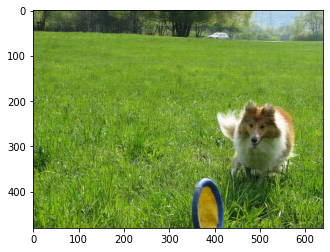

In [15]:
test_dl = DataLoader(ds)
for test_input, test_image in test_dl:
    pred_image = model(test_input.to(device)).detach().cpu()
    
    plt.imshow(test_image[0, ...].permute((1, 2, 0)) / 255)
    plt.show()
    
    plt.imshow(pred_image[0, ...].permute((1, 2, 0)) / 255)
    plt.show()
    
    break